In [14]:
from pathlib import Path

import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [15]:
data_dir = "./exp-local/data/old"


def import_data(dir):
    all_files = Path(dir).glob('*data.txt')
    all_data = [pd.read_fwf(path, skiprows=[1], index_col=None) for path in all_files]
    return pd.concat(all_data, axis=0, ignore_index=True)


data = import_data(data_dir)
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2,NaN
1,42781.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2,NaN
3,42784.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,43525.batch,batch,gl2_gl4,gl6,COMPLETED,2023-12-18T02:25:23,2023-12-18T02:47:29,203.27K,3874200K,5345.24M,805.05M,193711116K,00:22:06,32,NaN
509,44005,dpp-local-nc4_gl6-20.cfg,gl2_gl4,gl6,COMPLETED,2023-12-20T16:36:57,2023-12-20T17:52:59,NaN,NaN,NaN,NaN,NaN,01:16:02,4,NaN
510,44005.batch,batch,gl2_gl4,gl6,COMPLETED,2023-12-20T16:36:57,2023-12-20T17:52:59,524.61K,658816K,5345.24M,805.04M,26436040K,01:16:02,4,NaN
511,44008,daa-local-nc4_gl6-20.cfg,gl2_gl4,gl6,COMPLETED,2023-12-20T17:58:01,2023-12-21T11:26:37,NaN,NaN,NaN,NaN,NaN,17:28:36,4,NaN


In [16]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [17]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    dat.JobName = dat.JobName.replace('batch', method='ffill')
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(gl\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}K"] = dat[column] / 1000
        dat[f"{column}M"] = dat[column] / 1_000_000
        dat[f"{column}G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [18]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

data_completed = filter_out_completed_jobs(data)
data_completed = data_completed[~data_completed.JobName.str.contains("nc2")].reset_index(drop=True)

data_pending = data[data.State == "PENDING"]
data_pending = data_pending[~data_pending.JobName.str.contains("nc2")].reset_index(drop=True)

data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)
data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)

# data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)
data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_14604\3033834533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.JobName = dat.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskReadG,AveDiskWriteK,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours
8,42826.batch,daa-local-nc4_gl2-5.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-30T22:09:05,2023-12-01T14:41:24,3040000.0,1.296320e+09,8.838186e+10,...,88.38186,12728740.0,12728.74,12.72874,19389280.0,19389.280,19.389280,59539,992.316667,16.538611
9,42832.batch,daa-local-nc4_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-01T14:46:26,2023-12-02T07:20:32,3040000.0,1.192524e+09,8.838420e+10,...,88.38420,12731990.0,12731.99,12.73199,19387324.0,19387.324,19.387324,59646,994.100000,16.568333
13,42853.batch,daa-local-nc4_gl2-6.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-02T15:29:44,2023-12-03T07:57:43,3030000.0,1.181660e+09,8.838194e+10,...,88.38194,12728740.0,12728.74,12.72874,19389224.0,19389.224,19.389224,59279,987.983333,16.466389
16,42871.batch,daa-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-03T10:13:21,2023-12-04T02:39:18,3030000.0,1.164340e+09,8.838404e+10,...,88.38404,12731830.0,12731.83,12.73183,19388960.0,19388.960,19.388960,59157,985.950000,16.432500
17,42874.batch,daa-local-nc4_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-04T02:44:22,2023-12-04T19:10:36,3030000.0,1.185192e+09,8.838194e+10,...,88.38194,12728740.0,12728.74,12.72874,19388384.0,19388.384,19.388384,59174,986.233333,16.437222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,43189.batch,dpp-local-nc32_gl6-9.cfg,gl2_gl4,gl6,COMPLETED,2023-12-11T18:55:52,2023-12-11T19:16:50,196530.0,3.991680e+09,5.343420e+09,...,5.34342,804960.0,804.96,0.80496,193691408.0,193691.408,193.691408,1258,20.966667,0.349444
158,43213.batch,dpp-local-nc32_gl6-6.cfg,gl2_gl4,gl6,COMPLETED,2023-12-14T01:06:26,2023-12-14T01:27:28,198010.0,3.969780e+09,5.341880e+09,...,5.34188,804460.0,804.46,0.80446,193689624.0,193689.624,193.689624,1262,21.033333,0.350556
165,43246.batch,dpp-local-nc32_gl6-3.cfg,gl2_gl4,gl6,COMPLETED,2023-12-15T10:02:14,2023-12-15T10:24:18,201530.0,3.897232e+09,5.342720e+09,...,5.34272,804960.0,804.96,0.80496,193723732.0,193723.732,193.723732,1324,22.066667,0.367778
166,43249.batch,dpp-local-nc32_gl6-10.cfg,gl2_gl4,gl6,COMPLETED,2023-12-15T10:29:23,2023-12-15T10:51:43,203400.0,3.964100e+09,5.341960e+09,...,5.34196,804890.0,804.89,0.80489,193718664.0,193718.664,193.718664,1340,22.333333,0.372222


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial
0,42790.batch,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4,dpp,local,4,gl2,9
1,42793.batch,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4,dpp,local,4,gl2,3
2,42802.batch,dpp-local-nc4_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T13:24:15,2023-11-29T14:33:08,197.03K,629740K,5345.30M,802.60M,18558724K,01:08:53,4,dpp,local,4,gl2,2
3,42805.batch,dpp-local-nc8_gl2-4.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T14:38:13,2023-11-29T15:32:28,185.84K,1126708K,5345.41M,802.71M,36357232K,00:54:15,8,dpp,local,8,gl2,4
4,42808.batch,dpp-local-nc4_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T15:37:32,2023-11-29T16:46:21,196.80K,627348K,5345.42M,802.72M,18555848K,01:08:49,4,dpp,local,4,gl2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,43519.batch,dpp-local-nc4_gl6-12.cfg,gl2_gl4,gl6,COMPLETED,2023-12-17T14:54:40,2023-12-17T16:08:26,518.42K,672512K,5341.92M,804.47M,26490624K,01:13:46,4,dpp,local,4,gl6,12
176,43522.batch,daa-local-nc8_gl6-14.cfg,gl2_gl4,gl6,COMPLETED,2023-12-17T16:13:30,2023-12-18T02:20:19,4.84M,2601644K,88378.65M,12751.49M,52564156K,10:06:49,8,daa,local,8,gl6,14
177,43525.batch,dpp-local-nc32_gl6-11.cfg,gl2_gl4,gl6,COMPLETED,2023-12-18T02:25:23,2023-12-18T02:47:29,203.27K,3874200K,5345.24M,805.05M,193711116K,00:22:06,32,dpp,local,32,gl6,11
178,44005.batch,dpp-local-nc4_gl6-20.cfg,gl2_gl4,gl6,COMPLETED,2023-12-20T16:36:57,2023-12-20T17:52:59,524.61K,658816K,5345.24M,805.04M,26436040K,01:16:02,4,dpp,local,4,gl6,20


In [19]:
jobs_to_eliminate = data[data.ncores == 2]
" ".join(map(str, list(jobs_to_eliminate.JobID.to_list())))

''

In [20]:
collected_data_stats = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).describe().reset_index()
collected_data_stats.to_csv(
    'local_exp_overview_stats.csv', header=True)
collected_data_stats

Workflow   mode ncores node ConsumedEnergy                              \
                                        count          mean           std   
0       daa  local      4  gl2           10.0  3.038000e+06   7888.106377   
1       daa  local      4  gl5            8.0  6.625000e+06  30705.978943   
2       daa  local      4  gl6           10.0  7.558000e+06  42373.996219   
3       daa  local      8  gl2           10.0  2.740000e+06   4714.045208   
4       daa  local      8  gl5            5.0  4.132000e+06  25884.358211   
5       daa  local      8  gl6           11.0  4.762727e+06  54606.026973   
6       daa  local     16  gl5            8.0  2.780000e+06  17728.105209   
7       daa  local     16  gl6           10.0  3.192000e+06  33928.028400   
8       daa  local     32  gl5            9.0  2.418889e+06  12692.955176   
9       daa  local     32  gl6           10.0  2.707000e+06  22135.943621   
10      dpp  local      4  gl2           10.0  1.965890e+05    586.296285   
11      dpp  local      4  gl5            7.0  4.423971e+05   1261.344710   
12      dpp  local      4  gl6           10.0  5.146150e+05   4816.700692   
13      dpp  local      8  gl2           10.0  1.862380e+05    509.047040   
14      dpp  local      8  gl5            7.0  2.802457e+05   1701.566505   
15      dpp  local      8  gl6           10.0  3.236480e+05   3644.685019   
16      dpp  local     16  gl5            9.0  1.968022e+05   1821.035267   
17      dpp  local     16  gl6           10.0  2.263680e+05   3723.185016   
18      dpp  local     32  gl5            6.0  1.751517e+05   1918.920704   
19      dpp  local     32  gl6           10.0  1.987640e+05   2881.990824   

                                     ... ElapsedMinutes               \
          min        25%        50%  ...            75%          max   
0   3030000.0  3030000.0  3040000.0  ...     995.995833  1001.033333   
1   6600000.0  6607500.0  6615000.0  ...    1067.187500  1080.816667   
2   7510000.0  7532500.0  7550000.0  ...    1037.833333  1048.600000   
3   2730000.0  2740000.0  2740000.0  ...     783.654167   786.683333   
4   4110000.0  4110000.0  4120000.0  ...     615.150000   616.583333   
5   4700000.0  4715000.0  4780000.0  ...     600.575000   609.550000   
6   2770000.0  2770000.0  2770000.0  ...     353.462500   366.466667   
7   3150000.0  3172500.0  3185000.0  ...     355.425000   364.316667   
8   2410000.0  2410000.0  2420000.0  ...     277.016667   287.766667   
9   2690000.0  2692500.0  2700000.0  ...     279.412500   287.250000   
10   195420.0   196280.0   196835.0  ...      68.504167    68.883333   
11   440500.0   441625.0   442410.0  ...      74.633333    74.966667   
12   509860.0   511537.5   512630.0  ...      73.604167    76.033333   
13   185290.0   185912.5   186355.0  ...      54.441667    54.866667   
14   277870.0   279230.0   280200.0  ...      42.775000    43.250000   
15   320560.0   321190.0   321865.0  ...      42.020833    43.183333   
16   194210.0   196150.0   196710.0  ...      26.433333    28.350000   
17   222130.0   224287.5   225440.0  ...      27.466667    27.983333   
18   173450.0   173732.5   174555.0  ...      21.870833    22.950000   
19   195400.0   196862.5   197685.0  ...      22.000000    22.333333   

   ElapsedHours                                                        \
          count       mean       std        min        25%        50%   
0          10.0  16.535639  0.104931  16.375000  16.444514  16.553472   
1           8.0  17.726007  0.144941  17.594722  17.636667  17.652500   
2          10.0  17.266889  0.096293  17.164722  17.215000  17.242083   
3          10.0  13.037944  0.046180  12.959444  13.012083  13.042500   
4           5.0  10.089167  0.161008   9.954722   9.964722   9.997500   
5          11.0   9.921616  0.145312   9.739167   9.805833   9.958056   
6           8.0   5.884757  0.126015   5.805278   5.811667   5.822361   
7          10.0   5.908861  0.082972   5.832778   5.850833   5.880

In [21]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    n_trials=('trial', 'count'), trials_list=('trial', lambda x: sorted(x.tolist()))).reset_index()
collected_data.to_csv('local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,n_trials,trials_list
0,daa,local,4,gl2,10,"[1, 2, 3, 5, 6, 8, 11, 12, 13, 14]"
1,daa,local,4,gl5,8,"[10, 11, 12, 13, 14, 15, 16, 17]"
2,daa,local,4,gl6,10,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 20]"
3,daa,local,8,gl2,10,"[2, 3, 4, 5, 7, 8, 9, 10, 11, 20]"
4,daa,local,8,gl5,5,"[10, 11, 12, 14, 15]"
5,daa,local,8,gl6,11,"[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14]"
6,daa,local,16,gl5,8,"[10, 11, 12, 13, 14, 15, 16, 17]"
7,daa,local,16,gl6,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
8,daa,local,32,gl5,9,"[10, 11, 12, 13, 14, 15, 16, 17, 18]"
9,daa,local,32,gl6,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"


In [22]:
def to_local_config_class(workflow, node, trial, ncores, warmup=False):
    warmup_arg = ", True" if warmup else ""
    return f'LocalConfig("{workflow}", "{node}", {trial}, {ncores}{warmup_arg})'


def to_configs_array(x, start_idx):
    return f'[{to_local_config_class(x.Workflow, x.node, "trial", x.ncores)} for trial in range({start_idx}, {start_idx} + {x.trials_left_count})]'


def max_ncores(node):
    if node == 'gl2':
        return 8
    return 32


def get_configs_code_for_new_experiment(node, target_total_n, start_idx):
    exp_data = collected_data[(collected_data.node == node) & (
            collected_data.n_trials < target_total_n)]
    exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
    exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx)
    return " + ".join(exp_data.code.to_list()), to_local_config_class('dpp', node, start_idx,
                                                                      max_ncores(node), warmup=True)

In [23]:
TOTAL_EXPERIMENTS_PER_EPOCH = 10


def get_class_name(node, epoch):
    return f"LocalExperiment{node.upper()}_{epoch}"


def generate_class(node, epoch, target_total_n):
    configs, warmup_config = get_configs_code_for_new_experiment(node, target_total_n,
                                                                 (epoch - 1) * TOTAL_EXPERIMENTS_PER_EPOCH)
    class_definition = \
        f"""
from typing import List

from examples.domain import LocalExperiment
from examples.domain.Config import Config
from examples.domain.LocalConfig import LocalConfig


class {get_class_name(node, epoch)}(LocalExperiment):
    def create_configs(self) -> List[Config]:
        return {configs}

    def create_warmup_config(self) -> Config:
        return {warmup_config}
"""
    return class_definition if configs else None

In [24]:
# new experiment epochs
def generate_experiment_classes(exp_epochs):
    for node, epoch in exp_epochs.items():
        class_code = generate_class(node, epoch, TOTAL_EXPERIMENTS_PER_EPOCH)
        if class_code is None:
            continue

        file_path = f"../examples/domain/{get_class_name(node, epoch)}.py"
        with open(file_path, 'w') as file:
            file.write(class_code)


generate_experiment_classes({
    "gl2": 3,
    "gl6": 3,
    "gl5": 2
})

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_14604\2293699696.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_14604\2293699696.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx)


In [25]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_trials_completed,n_trials_threshold
8,42826.batch,daa-local-nc4_gl2-5.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-30T22:09:05,2023-12-01T14:41:24,3040000.0,1.296320e+09,8.838186e+10,...,12728.74,12.72874,19389280.0,19389.280,19.389280,59539,992.316667,16.538611,10,True
9,42832.batch,daa-local-nc4_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-01T14:46:26,2023-12-02T07:20:32,3040000.0,1.192524e+09,8.838420e+10,...,12731.99,12.73199,19387324.0,19387.324,19.387324,59646,994.100000,16.568333,10,True
13,42853.batch,daa-local-nc4_gl2-6.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-02T15:29:44,2023-12-03T07:57:43,3030000.0,1.181660e+09,8.838194e+10,...,12728.74,12.72874,19389224.0,19389.224,19.389224,59279,987.983333,16.466389,10,True
16,42871.batch,daa-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-03T10:13:21,2023-12-04T02:39:18,3030000.0,1.164340e+09,8.838404e+10,...,12731.83,12.73183,19388960.0,19388.960,19.388960,59157,985.950000,16.432500,10,True
17,42874.batch,daa-local-nc4_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-04T02:44:22,2023-12-04T19:10:36,3030000.0,1.185192e+09,8.838194e+10,...,12728.74,12.72874,19388384.0,19388.384,19.388384,59174,986.233333,16.437222,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,43189.batch,dpp-local-nc32_gl6-9.cfg,gl2_gl4,gl6,COMPLETED,2023-12-11T18:55:52,2023-12-11T19:16:50,196530.0,3.991680e+09,5.343420e+09,...,804.96,0.80496,193691408.0,193691.408,193.691408,1258,20.966667,0.349444,10,True
158,43213.batch,dpp-local-nc32_gl6-6.cfg,gl2_gl4,gl6,COMPLETED,2023-12-14T01:06:26,2023-12-14T01:27:28,198010.0,3.969780e+09,5.341880e+09,...,804.46,0.80446,193689624.0,193689.624,193.689624,1262,21.033333,0.350556,10,True
165,43246.batch,dpp-local-nc32_gl6-3.cfg,gl2_gl4,gl6,COMPLETED,2023-12-15T10:02:14,2023-12-15T10:24:18,201530.0,3.897232e+09,5.342720e+09,...,804.96,0.80496,193723732.0,193723.732,193.723732,1324,22.066667,0.367778,10,True
166,43249.batch,dpp-local-nc32_gl6-10.cfg,gl2_gl4,gl6,COMPLETED,2023-12-15T10:29:23,2023-12-15T10:51:43,203400.0,3.964100e+09,5.341960e+09,...,804.89,0.80489,193718664.0,193718.664,193.718664,1340,22.333333,0.372222,10,True


In [26]:
import matplotlib.pyplot as plt

In [27]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

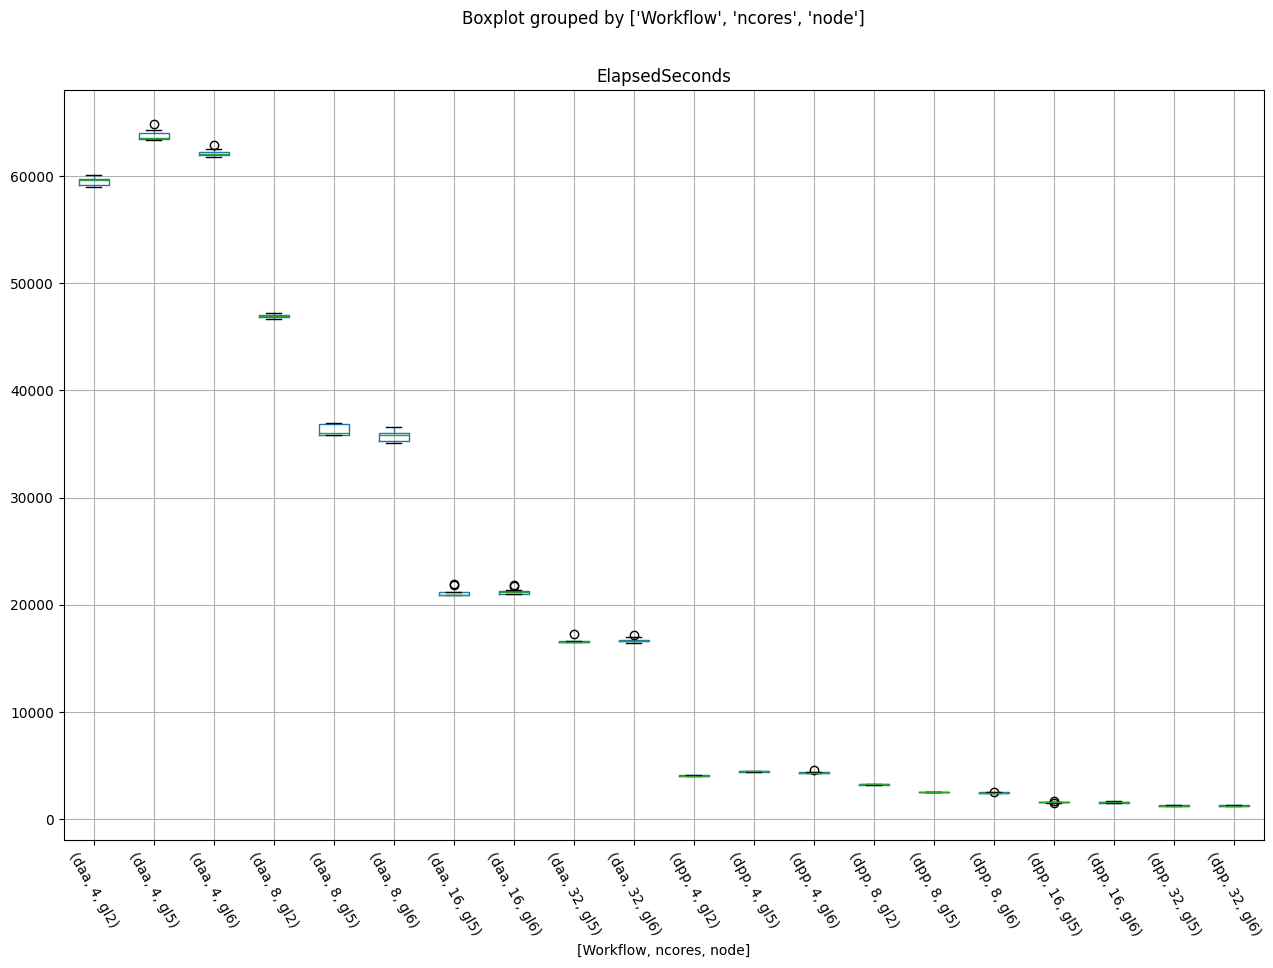

In [28]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60)
# save
fig.savefig('boxplot.png')


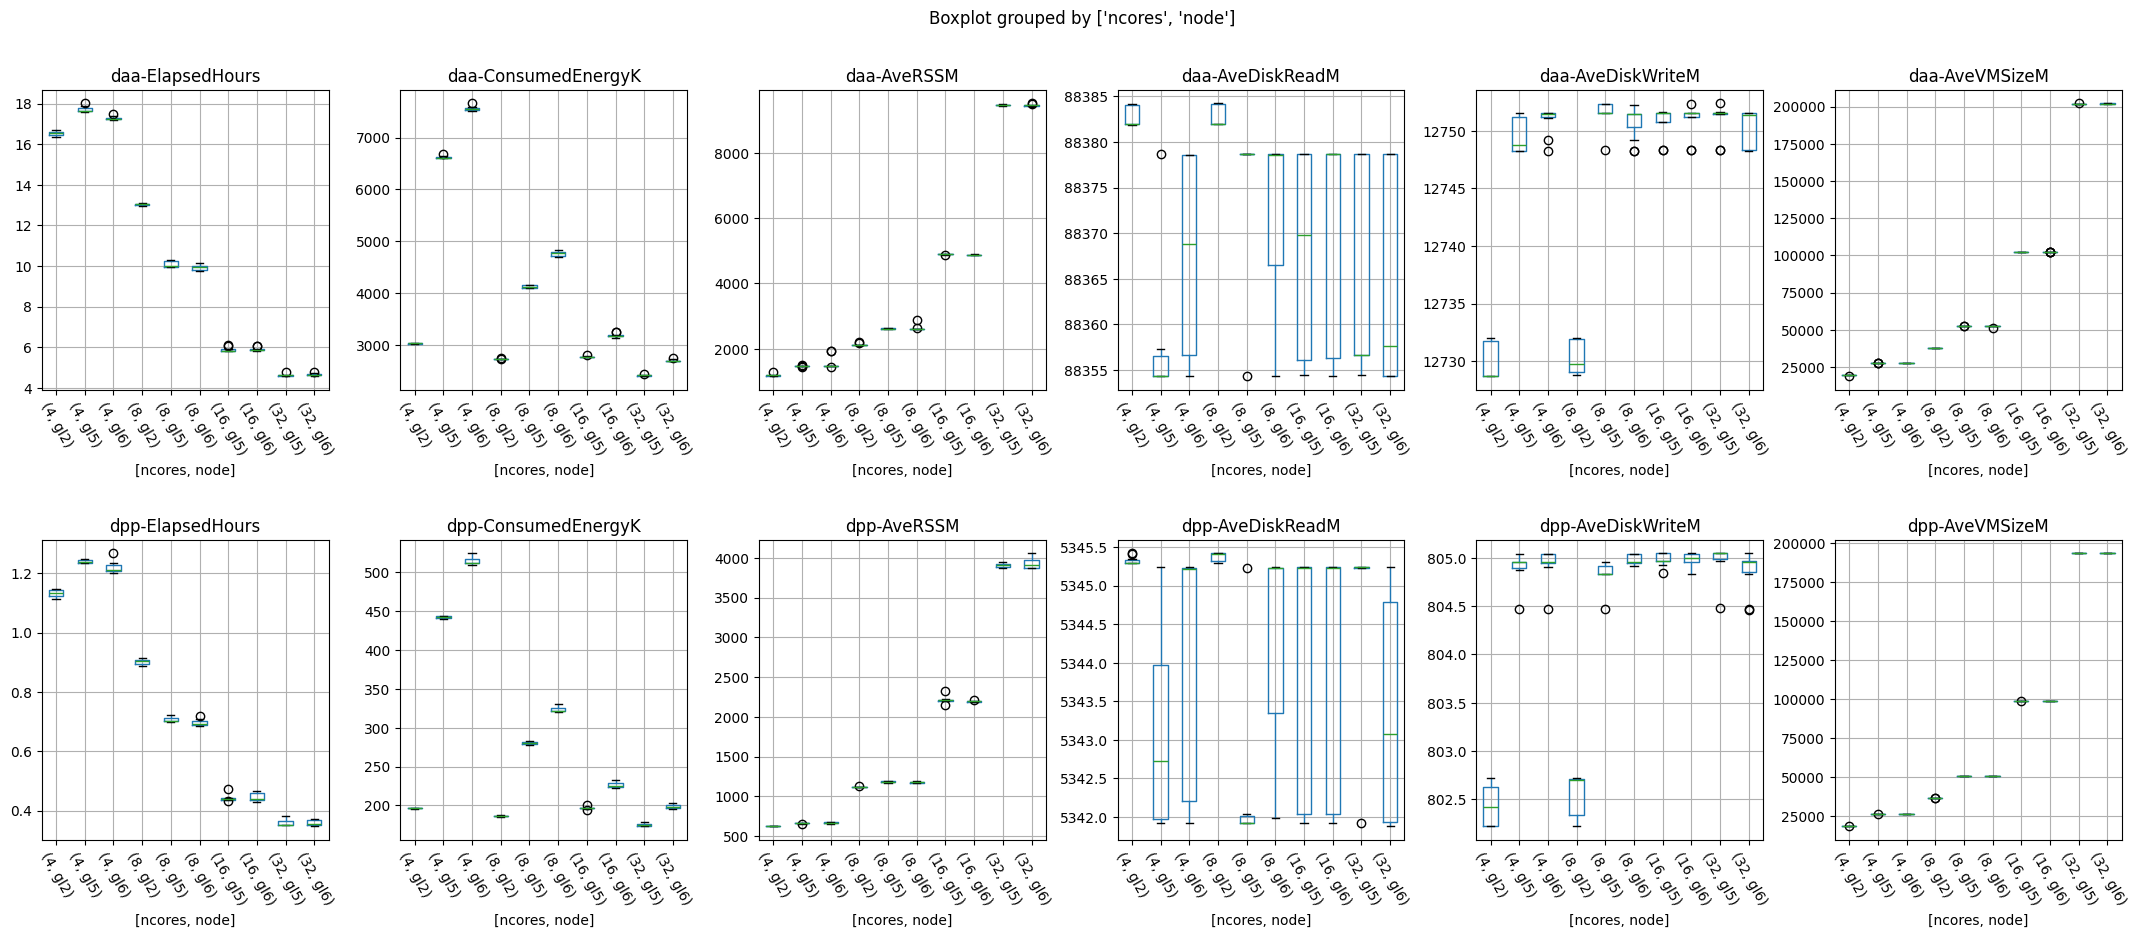

In [29]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
        data_for_analysis[data_for_analysis.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'],
                                                                          ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60)
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('boxplot-overview-by-workflows.png')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(26, 10))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
    data_for_analysis.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60)

fig.subplots_adjust(hspace=0.6)

fig.savefig('boxplot-overview.png')